In [78]:
from pathlib import Path
import pandas as pd
import gc
from sklearn.preprocessing import LabelEncoder
import pickle
import bz2
from scipy import stats
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

Download https://drive.google.com/drive/folders/1BZFez3OFs7QMzeDUz-8E0SgnRy227pnG

Unzip

!mkdir data
!tar -xf inno_stats.tar.gz -C ./data

In [54]:
data_path = Path('./data/').resolve()
!ls {data_path}

09_groups.csv       outliers.pkl.bz2    product_groups.docx
bad_ids.csv         product_groups.csv


In [56]:
df = pd.read_csv('./data/09_groups.csv')
df

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091
...,...,...,...,...,...,...,...,...,...,...
42100853,2020-09-30 11:26:28,4850561,0.0,1739990,25292,17528,1.0,130.00,0,10099
42100854,2020-09-30 08:12:39,10015419,0.0,1761351,30740,19188,2.0,120.00,0,10008
42100855,2020-09-30 09:54:24,22816791,0.0,1432778,30741,19188,1.0,73.00,0,10254
42100856,2020-09-30 12:00:04,1648929,0.0,484390,34835,15916,1.0,78.00,0,10099


In [59]:
bad_ids = pd.read_csv('./data/bad_ids.csv')
bad_ids = bad_ids['id_card'].to_list()

df = df[~df['id_card'].isin(bad_ids)]
df

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091
...,...,...,...,...,...,...,...,...,...,...
42100853,2020-09-30 11:26:28,4850561,0.0,1739990,25292,17528,1.0,130.00,0,10099
42100854,2020-09-30 08:12:39,10015419,0.0,1761351,30740,19188,2.0,120.00,0,10008
42100855,2020-09-30 09:54:24,22816791,0.0,1432778,30741,19188,1.0,73.00,0,10254
42100856,2020-09-30 12:00:04,1648929,0.0,484390,34835,15916,1.0,78.00,0,10099


In [10]:
p_g = pd.read_csv('./data/product_groups.csv', delimiter=';', encoding='windows-1251')
p_g.head()

,id_tov,id_group,name_group
0,52,10004,Кисломолочные продукты
1,75,10004,Кисломолочные продукты
2,77,10004,Кисломолочные продукты
3,143,10004,Кисломолочные продукты
4,151,10004,Кисломолочные продукты


## Task 1

Prove that buying discounted products depends on the average order sum. (It is more probable that the discounted product will be bought if bunch of money is going to be spend)

**Let's find the number of discounted products for each receipt and group the purchases by the number of discounted goods in them (number_of_discounts). Similarly, let's calculate the average check amount for each of the quantities of discount items in the order (sums_by_discounts).**

In [90]:
number_of_discounts = df.groupby('id_doc').sum().groupby('is_green').count()['id_order']
sums_by_discounts = df.groupby('id_doc').sum().groupby('is_green').sum()['sum']

correlation = sums_by_discounts / number_of_discounts

In [103]:
pp = stats.pearsonr(sums_by_discounts, number_of_discounts)
print('Pearson correlation: ', "{:.4f}".format(pp[0]))
print('p-value: ', "{:.4f}".format(pp[1]))

Pearson correlation:  0.9999
p-value:  0.0000


**The computed Pearson correlation coefficient is close to 1, hence, implies a linear relationship between the number of discounts in a receipt and an average sum of such receipt.**

<AxesSubplot:xlabel='Number of discounts in one receipt', ylabel='Average sum of receipt'>

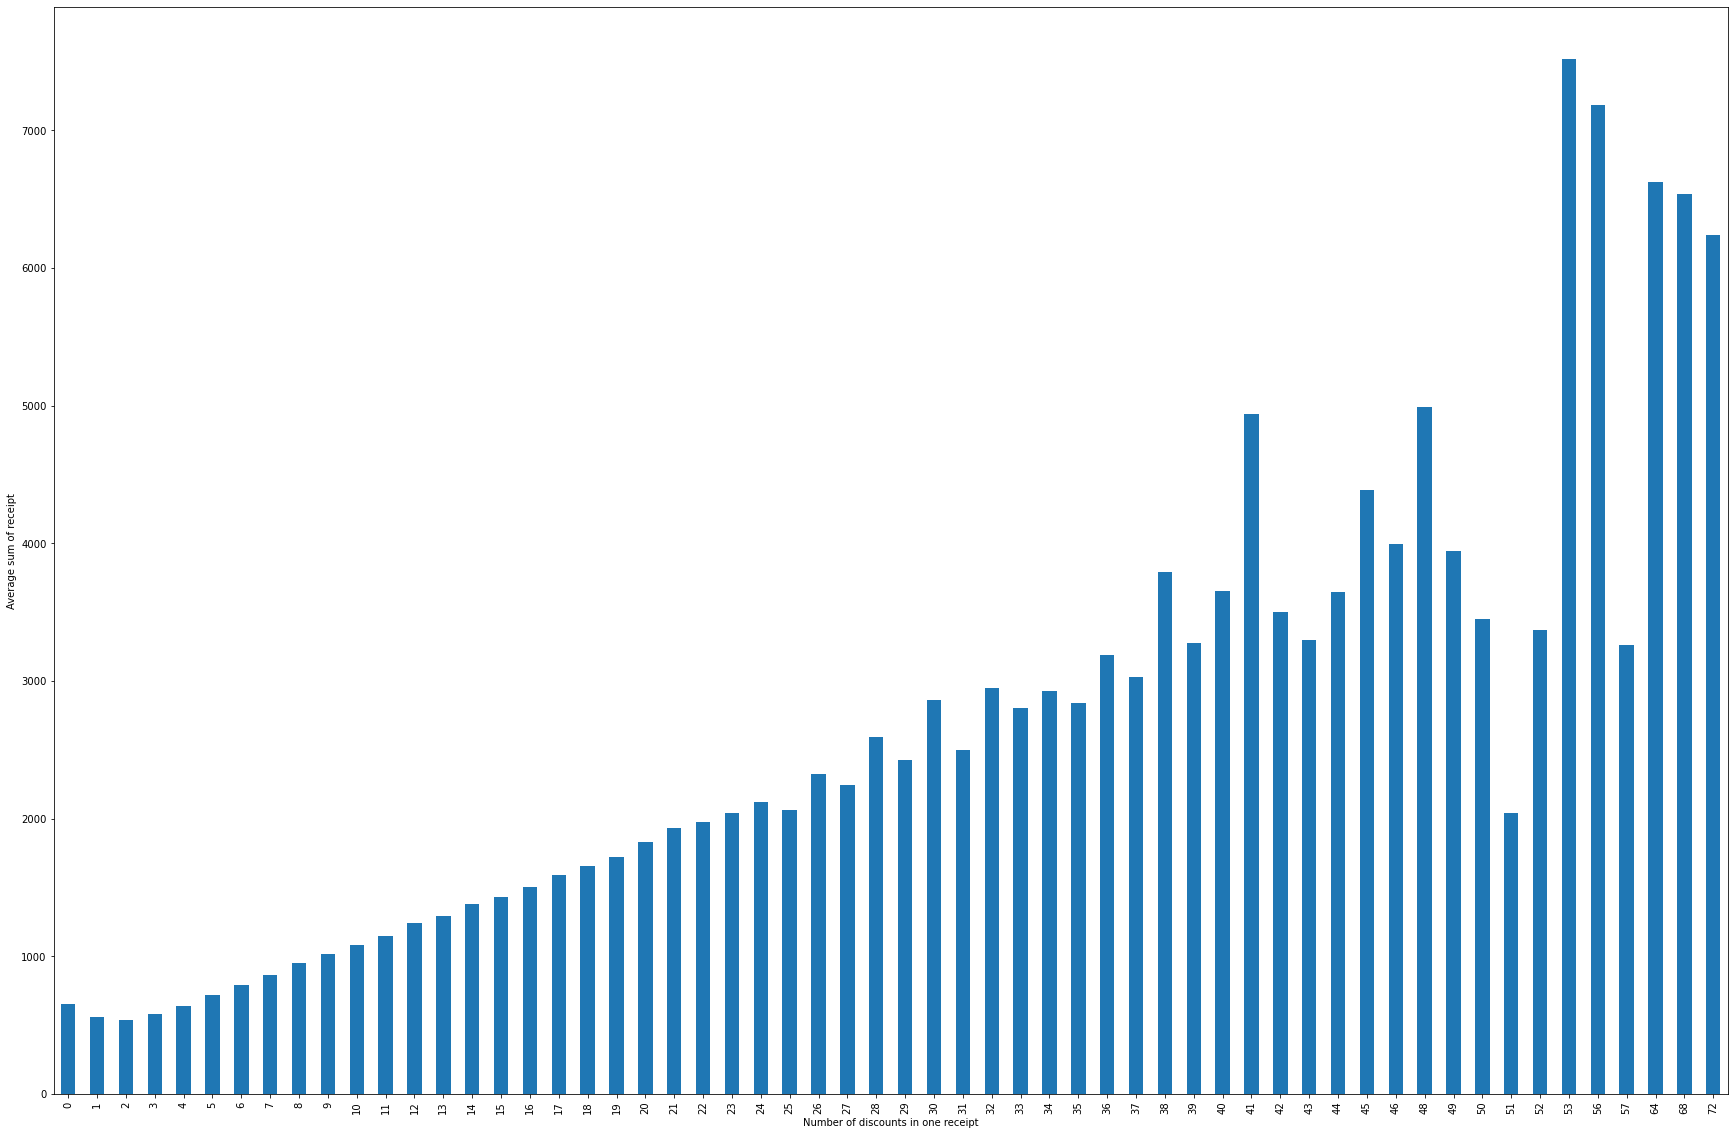

In [105]:
plt.figure(figsize=(30,20))
correlation.plot(kind='bar', xlabel='Number of discounts in one receipt', ylabel='Average sum of receipt')

## Task 2
Prove that the frequency of shopping grows around the wage taking days.

Null hypothesis: the frequency of shopping grows around the wage taking days (1-6, 20-26)

In [108]:
df.index = pd.to_datetime(df['date'],format='%Y-%m-%d %H:%M:%S')
df

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
date,,,,,,,,,,
2020-09-01 17:01:25,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
2020-09-01 17:35:36,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2020-09-01 19:19:21,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
2020-09-01 21:53:34,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
2020-09-01 18:42:31,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091
...,...,...,...,...,...,...,...,...,...,...
2020-09-30 11:26:28,2020-09-30 11:26:28,4850561,0.0,1739990,25292,17528,1.0,130.00,0,10099
2020-09-30 08:12:39,2020-09-30 08:12:39,10015419,0.0,1761351,30740,19188,2.0,120.00,0,10008
2020-09-30 09:54:24,2020-09-30 09:54:24,22816791,0.0,1432778,30741,19188,1.0,73.00,0,10254


In [117]:
shopping_frequency = df.groupby([df.index.day])['id_doc'].count()

<AxesSubplot:xlabel='Day', ylabel='Shopping frequency'>

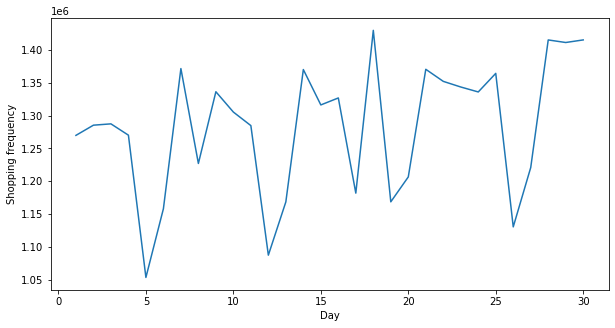

In [125]:
plt.figure(figsize=(10,5))
shopping_frequency.plot(xlabel='Day', ylabel='Shopping frequency')

**Since we can observe a decrease in the number of purchases on the 5th and on the 26th, the hypothesis is rejected.**

## Task 3
Define such cohort existance:
1. Frequent buyers - The users that are shopping frequently(daily, weekly, monthly) 
2. Average purchase sum - The customers that usually spend the same amount of money 
3. Orders amount - The customers grouped by the total numer of orders 
4. Usual cart - The customers grouped by the product groups

References
- https://towardsdatascience.com/a-step-by-step-introduction-to-cohort-analysis-in-python-a2cbbd8460ea

### Frequent buyers

In [166]:
per_day = df.groupby(['id_card', df.index.day]).count()
per_day = per_day.groupby('id_card').count()
one_order_per_day = np.asarray(per_day[per_day['sum'] >= 30].index.tolist())
print('buyers who make purchases on a daily basis')
one_order_per_day

buyers who make purchases on a daily basis


array([   5096,    6183,   57303,   58154,  121629,  184349,  190267,
        200025,  219805,  333896,  360536,  439307,  486190,  503718,
        521971,  537739,  550152,  569448,  612380,  620767,  777364,
        904949,  919837,  974512, 1002800, 1032222, 1109850, 1126944,
       1144271, 1160908, 1184159, 1198040, 1230989, 1308754, 1322471,
       1334945, 1430373, 1456677, 1472222, 1494193, 1507020, 1521626,
       1572850, 1583742, 1648549, 1790219, 1804583, 1824958])

### Average purchase sum

In [177]:
average = pd.DataFrame()
average['std'] = df.groupby(['id_card'])['sum'].std()

average['mean'] = df.groupby(['id_card'])['sum'].mean()
average['median'] = df.groupby(['id_card'])['sum'].median()

average['between'] = average['mean'] - average['median']
average['between'] = average['between'].abs()

average = average[average['std'] <= average['between']]
average.index.tolist()

[1565,
 1928,
 2078,
 2519,
 3403,
 3775,
 4760,
 5514,
 5810,
 6003,
 6326,
 7021,
 7694,
 8036,
 8232,
 8481,
 8638,
 8974,
 9173,
 10004,
 10024,
 10297,
 10377,
 10385,
 10881,
 11030,
 11042,
 11974,
 12437,
 14304,
 14516,
 14939,
 15103,
 15603,
 15801,
 15858,
 16070,
 16380,
 17147,
 17937,
 18153,
 18155,
 18212,
 18426,
 18583,
 19265,
 19635,
 20076,
 20583,
 21887,
 21980,
 22120,
 22132,
 23729,
 23815,
 24259,
 24578,
 25860,
 26182,
 26326,
 27390,
 27539,
 28723,
 29287,
 29758,
 30017,
 30063,
 30743,
 30793,
 31251,
 31548,
 31739,
 32208,
 32269,
 32365,
 32725,
 34081,
 34153,
 35671,
 35753,
 35765,
 36600,
 36757,
 36797,
 37277,
 37396,
 37418,
 37605,
 37978,
 38718,
 38808,
 38813,
 38849,
 38882,
 39128,
 39229,
 40125,
 40247,
 41261,
 41300,
 41547,
 42874,
 43121,
 43392,
 44189,
 44254,
 44808,
 45149,
 46480,
 46722,
 46927,
 46965,
 47023,
 47204,
 48026,
 48953,
 49239,
 49635,
 49835,
 50381,
 50597,
 50693,
 50886,
 50942,
 52239,
 52296,
 52954,
 53

### Usual cart

<AxesSubplot:xlabel='Product group', ylabel='Number of customers'>

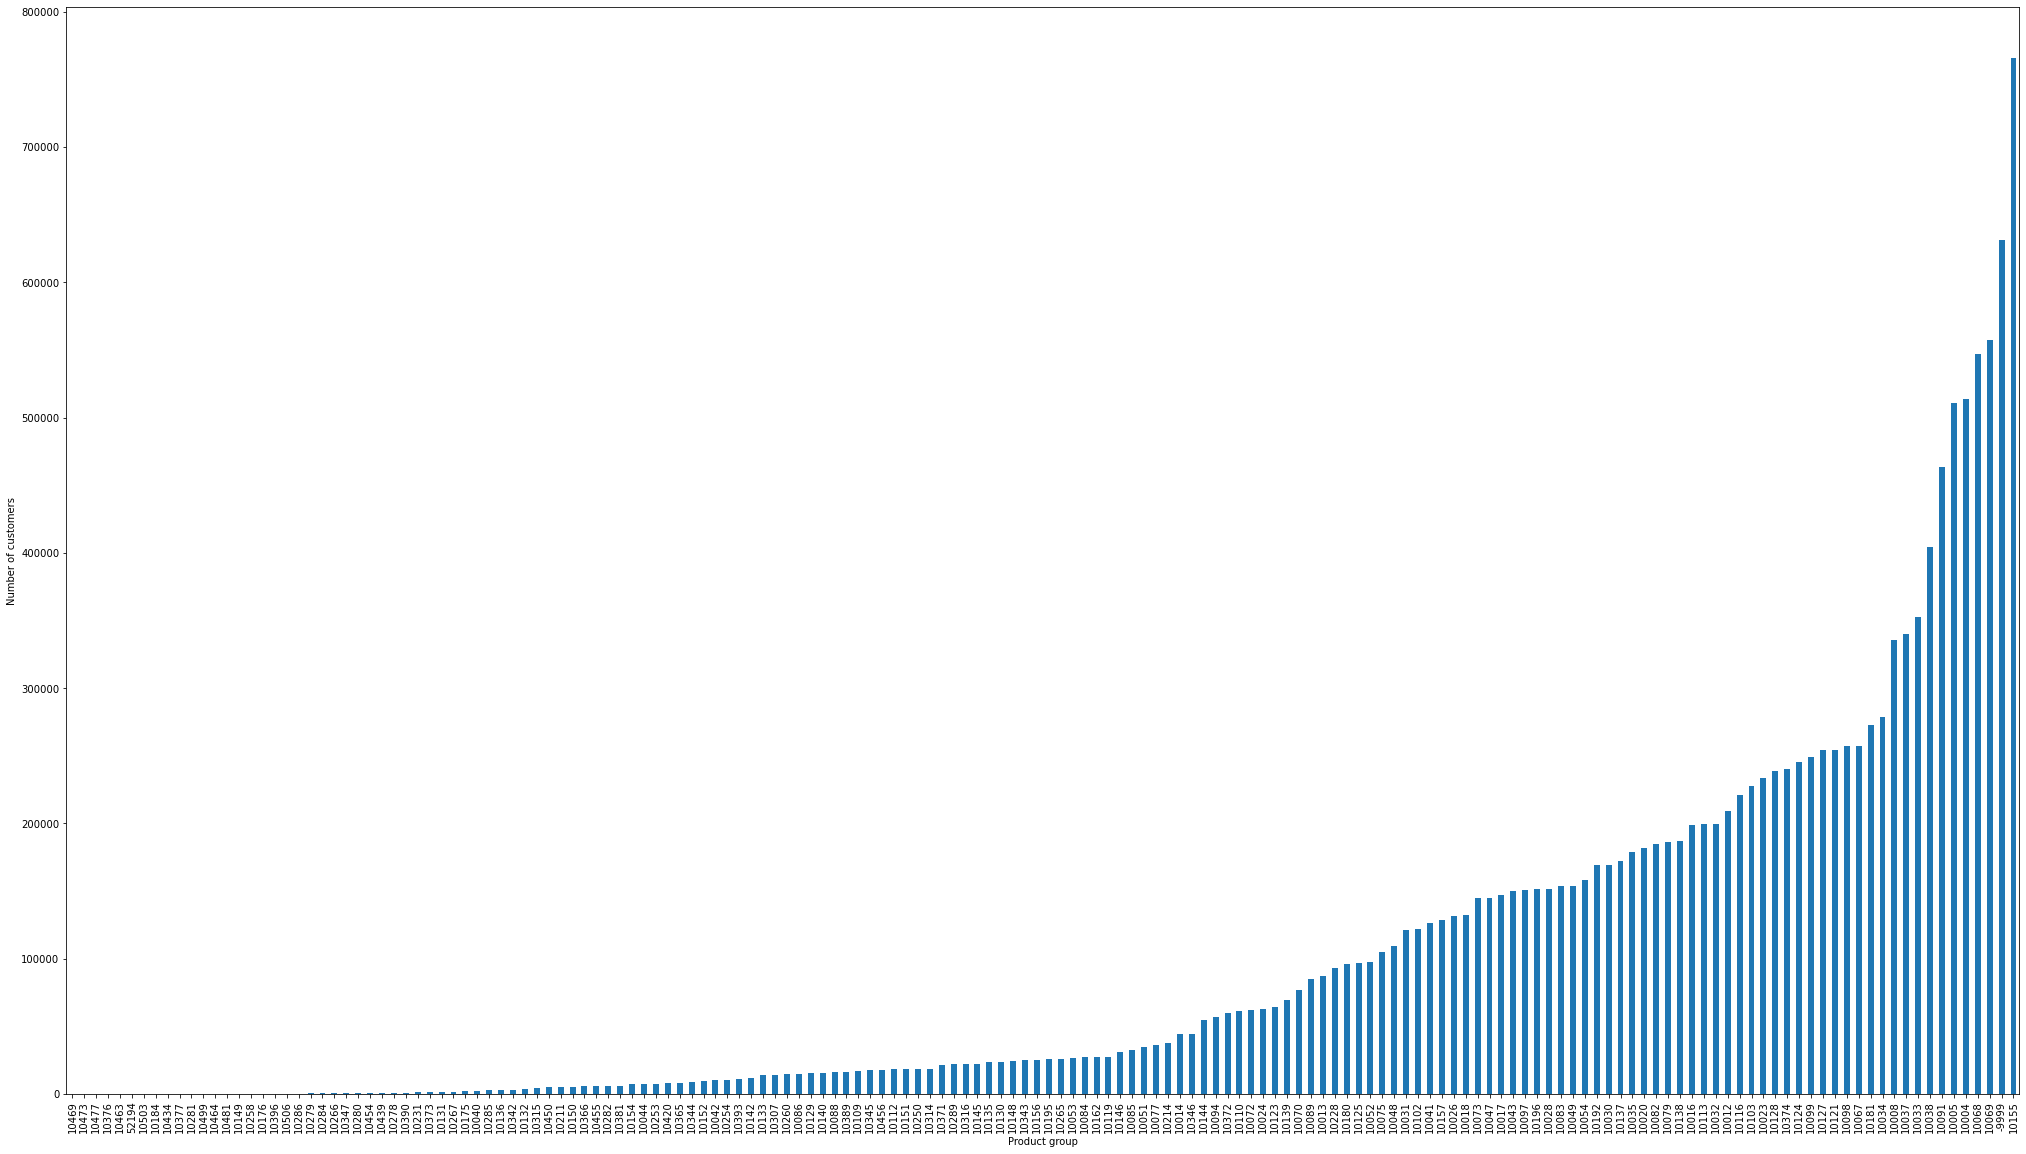

In [181]:
customers_groups = df.groupby('id_group')['id_card'].unique().apply(len)

plt.figure(figsize=(35,20))
customers_groups.sort_values().plot(kind='bar',xlabel='Product group', ylabel='Number of customers')